In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_rows', 100)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

import warnings
warnings.filterwarnings("ignore")

In [2]:
def aic(y,y_pred, X):
    
    # Compute the residual sum of squares (RSS)
    RSS = np.sum((y - y_pred)**2)

    # Compute the number of parameters in the model
    k = X.shape[1] + 1

    # Compute the AIC score
    AIC = 2*k - 2*np.log(RSS)

    return AIC

### Loading the data:

In [3]:
import os

# set the directory containing the CSV files
directory = 'input data'

# create an empty list to hold all the dataframes
df_list = []

# iterate over all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        # read the CSV file into a pandas dataframe
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        
        # append the dataframe to the list
        df_list.append(df)

# concatenate all dataframes in the list into a single dataframe
data = pd.concat(df_list, ignore_index=True)

# print the resulting dataframe
data.head()

,Record ID,Date Time,Solar Avg,Unnamed: 3
0,203.00,01-03-22 0:00,0.00,NaN
1,204.00,01-03-22 0:01,0.00,NaN
2,205.00,01-03-22 0:02,0.00,NaN
3,206.00,01-03-22 0:03,0.00,NaN
4,207.00,01-03-22 0:04,0.00,NaN


In [4]:
data = data.drop(['Record ID','Unnamed: 3'], axis=1)
data.dropna(inplace=True)
data['Date Time'] = pd.to_datetime(data['Date Time'])
data = data.loc[data['Date Time'] <= '2023-03']
data['Date Time'] = data['Date Time'].dt.round('H')
data = data.groupby('Date Time').mean().reset_index()
data.sort_values(by='Date Time',inplace=True)
data.set_index('Date Time', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7651 entries, 2022-01-03 00:00:00 to 2023-03-01 00:00:00
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Solar Avg  7651 non-null   float64
dtypes: float64(1)
memory usage: 119.5 KB


data = data.drop(['Record ID','Unnamed: 3'], axis=1): This line drops two columns named 'Record ID' and 'Unnamed: 3' from the DataFrame data. The axis=1 argument specifies that columns should be dropped.

data.dropna(inplace=True): This line drops all rows from the DataFrame data that contain missing (NaN) values. The inplace=True argument specifies that the DataFrame should be modified in place.

data['Date Time'] = pd.to_datetime(data['Date Time']): This line converts the values in the 'Date Time' column of the DataFrame data to datetime objects using the pd.to_datetime() function. This is done so that the values can be easily sorted and indexed later.

data.drop_duplicates(subset='Date Time',inplace=True): This line drops any rows from the DataFrame data that have duplicate values in the 'Date Time' column. The inplace=True argument specifies that the DataFrame should be modified in place.

data.sort_values(by='Date Time',inplace=True): This line sorts the rows of the DataFrame data by the values in the 'Date Time' column. The inplace=True argument specifies that the DataFrame should be modified in place.

data.set_index('Date Time', inplace=True): This line sets the 'Date Time' column as the index of the DataFrame data. This means that the DataFrame will be indexed by dates and times, which will be useful for time series analysis.

data.info(): This line prints out some basic information about the DataFrame data, including its shape (number of rows and columns), the data types of its columns, and the number of non-null values in each column.

In [5]:
del df_list

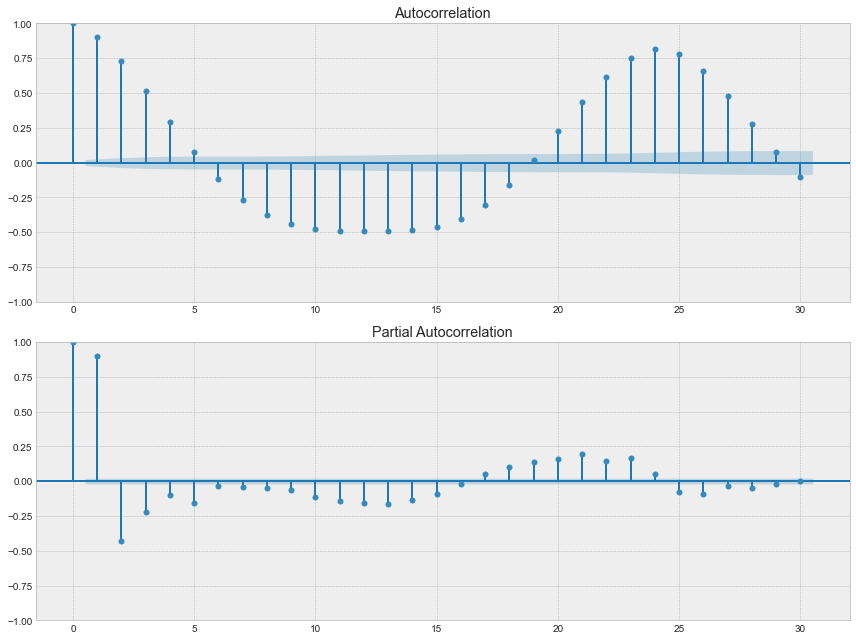

In [6]:
import statsmodels.formula.api as smf        
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

data.sort_index(inplace=True)
with plt.style.context('bmh'):    
    fig = plt.figure(figsize=(12, 9))
    layout = (2, 1)
    acf_ax = plt.subplot2grid(layout, (0, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 0))
    
    smt.graphics.plot_pacf(data['Solar Avg'], ax=pacf_ax,lags=30)
    smt.graphics.plot_acf(data['Solar Avg'], ax=acf_ax,lags=30)
    plt.tight_layout()

This code imports necessary libraries and then creates a figure with two subplots to display the autocorrelation and partial autocorrelation functions for a time series dataset. The sort_index method is called to ensure the data is sorted in the correct order, and then the plot_acf and plot_pacf functions are called to generate the desired plots.

In [7]:
# Genrating needed lags:
for i in range(1,14):
    data["lag_{}".format(i)] = data['Solar Avg'].shift(i)
data.dropna(axis=0,inplace=True)
data.head()

,Solar Avg,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13
Date Time,,,,,,,,,,,,,,
2022-01-03 13:00:00,995.37,943.70,959.81,1141.83,690.23,259.15,71.05,0.75,0.00,0.00,0.00,0.00,0.00,0.00
2022-01-03 14:00:00,955.11,995.37,943.70,959.81,1141.83,690.23,259.15,71.05,0.75,0.00,0.00,0.00,0.00,0.00
2022-01-03 15:00:00,810.54,955.11,995.37,943.70,959.81,1141.83,690.23,259.15,71.05,0.75,0.00,0.00,0.00,0.00
2022-01-03 16:00:00,396.28,810.54,955.11,995.37,943.70,959.81,1141.83,690.23,259.15,71.05,0.75,0.00,0.00,0.00
2022-01-03 17:00:00,195.93,396.28,810.54,955.11,995.37,943.70,959.81,1141.83,690.23,259.15,71.05,0.75,0.00,0.00


In [8]:
import requests
import json

response = requests.post("https://llmapi-zareiqouxa-lz.a.run.app/chat")

if response.status_code == 200:
    data = json.loads(response.text)
    print(data)
else:
    print("Request failed with status code:", response.status_code)

Request failed with status code: 404


#### Plotting the correlations:

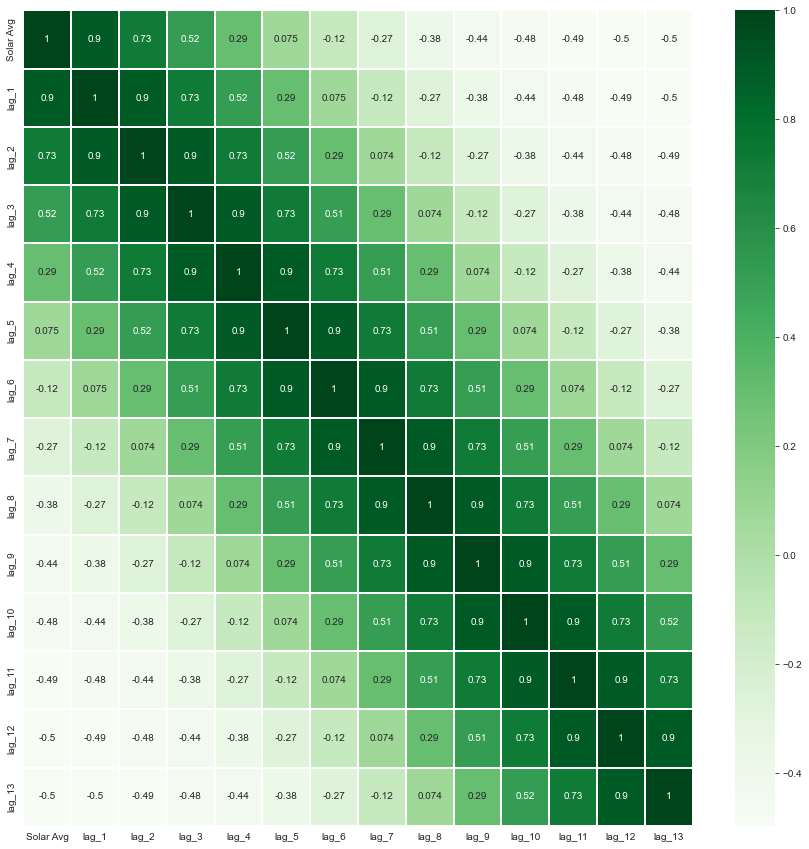

In [9]:
plt.figure(figsize=(15, 15))
sns.heatmap(data.corr(), annot=True, cmap="Greens", linewidths=0.1, annot_kws={"fontsize":10});

In [10]:
data.reset_index().to_csv('plotting data/Full Data.csv')

In [11]:
# Creating train and test sets:
X = data.drop(['Solar Avg'], axis =1)
y = data['Solar Avg'].to_frame()

# Scaling the data. 
data_scaler = StandardScaler()
target_scaler = StandardScaler()

scaled_data = data_scaler.fit_transform(X.values)
scaled_target = target_scaler.fit_transform(y.values)

scaled_data= pd.DataFrame(scaled_data, index=X.index, columns=X.columns)
scaled_target= pd.DataFrame(scaled_target, index=y.index, columns=y.columns)

x_train, x_test, y_train, y_test = train_test_split(scaled_data,scaled_target,test_size=0.2,shuffle=False, stratify = None)

this code performs data preprocessing tasks by splitting the original dataset into features and target dataframes, standardizing the data using the StandardScaler class, and splitting the data into training and testing sets using the train_test_split function.

## LSTM:

In [12]:
!pip install bayesian-optimization

In [13]:
from keras.layers import LSTM, Dense
from keras.models import Sequential
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor

from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error

# Define the LSTM model
def create_lstm_model(units_1, units_2, learning_rate):
    model = Sequential()
    model.add(LSTM(units_1, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(units_2, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    adam = optimizers.Adam(lr=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=adam)
    return model

# Define the search space for Bayesian Optimization
pbounds = {'units_1': (64, 256),
           'units_2': (32, 128),
           'learning_rate': (0.001, 0.1)}

# Define the objective function for Bayesian Optimization
def lstm_cv(units_1, units_2, learning_rate):
    model = create_lstm_model(units_1=int(units_1), units_2=int(units_2), learning_rate=learning_rate)
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=32, verbose=0)
    mse = mean_squared_error(y_test, model.predict(x_test))
    return -mse

# Perform Bayesian Optimization
lstm_bo = BayesianOptimization(f=lstm_cv, pbounds=pbounds, random_state=42)
lstm_bo.maximize(init_points=5, n_iter=10)

# Print the best hyperparameters
print("Best: %f using %s" % (-lstm_bo.max['target'], lstm_bo.max['params']))

|   iter    |  target   | learni... |  units_1  |  units_2  |
-------------------------------------------------------------
48/48 [==============================] - 1s 4ms/step
| 1         | -0.3121   | 0.03808   | 246.5     | 102.3     |
48/48 [==============================] - 1s 3ms/step
| 2         | -0.2455   | 0.06027   | 93.96     | 46.98     |
48/48 [==============================] - 1s 8ms/step
| 3         | -0.1886   | 0.00675   | 230.3     | 89.71     |
48/48 [==============================] - 2s 7ms/step
| 4         | -0.3051   | 0.0711    | 67.95     | 125.1     |
48/48 [==============================] - 2s 11ms/step
| 5         | -0.3735   | 0.08341   | 104.8     | 49.46     |
48/48 [==============================] - 1s 8ms/step
| 6         | -0.263    | 0.01355   | 230.4     | 88.98     |
48/48 [==============================] - 2s 9ms/step
| 7         | -1.203    | 0.08618   | 230.4     | 90.04     |
48/48 [==============================] - 2s 9ms/step
| 8         | -0.

this code performs hyperparameter tuning for an LSTM model by creating a function that defines the model architecture, creating a KerasRegressor object from the function, defining a dictionary of hyperparameters to tune, and using GridSearchCV to find the best hyperparameters.

In [ ]:
lstm_bo.max['params']

{'learning_rate': 0.001,
 'units_1': 254.60802666314538,
 'units_2': 93.94112758696221}

In [ ]:
from tensorflow.keras import callbacks

lstm_model = create_lstm_model(learning_rate=lstm_bo.max['params']['learning_rate'],
                          units_1=round(lstm_bo.max['params']['units_1']),
                          units_2=round(lstm_bo.max['params']['units_2']))

early_stopping = callbacks.EarlyStopping(monitor='loss', patience=5, min_delta=0.001, restore_best_weights = True)

lstm_model.fit(x_train, y_train, epochs=50, callbacks=[early_stopping])

This code trains the LSTM model with the best hyperparameters found using GridSearchCV in the previous code block.

In [ ]:
LSTMpredictions = lstm_model.predict(x_test)
LSTMpredictions = target_scaler.inverse_transform(LSTMpredictions)
y_test_descaled = target_scaler.inverse_transform(y_test)
lstmmae = mean_absolute_error(y_test_descaled, LSTMpredictions)
lstmmse = mean_squared_error(y_test_descaled, LSTMpredictions)
lstmrmse = np.sqrt(lstmmse)
lstmr2 = r2_score(y_test_descaled, LSTMpredictions)
lstmaic = aic(y_test, LSTMpredictions, x_test)
lstmmape = mean_absolute_percentage_error(y_test, LSTMpredictions) * 100
print(f'''
(a) LSTM Mean Absolute Error (lstmMAE): {lstmmae}
(b) LSTM Mean Squared Error (MlstmSE): {lstmmse}
(c) LSTM Root Mean Squared Errlstmor (RMSE): {lstmrmse}
(d) LSTM R² (R-Squared):{lstmr2}
(e) LSTM AIC : {lstmaic.iloc[0]}
(f) LSTM MAPE : {lstmmape}
''')

48/48 [==============================] - 1s 9ms/step

(a) LSTM Mean Absolute Error (lstmMAE): 57.70151214293091
(b) LSTM Mean Squared Error (MlstmSE): 17365.25126950486
(c) LSTM Root Mean Squared Errlstmor (RMSE): 131.7772790336212
(d) LSTM R² (R-Squared):0.8495514572819686
(e) LSTM AIC : -10.30915146210338
(f) LSTM MAPE : 49906.96874777998



#### Plotting the LSTM predictions:

In [ ]:
train = data[:len(x_train)]
lstmvalid = data[len(x_train):]
lstmvalid['Predictions'] = LSTMpredictions

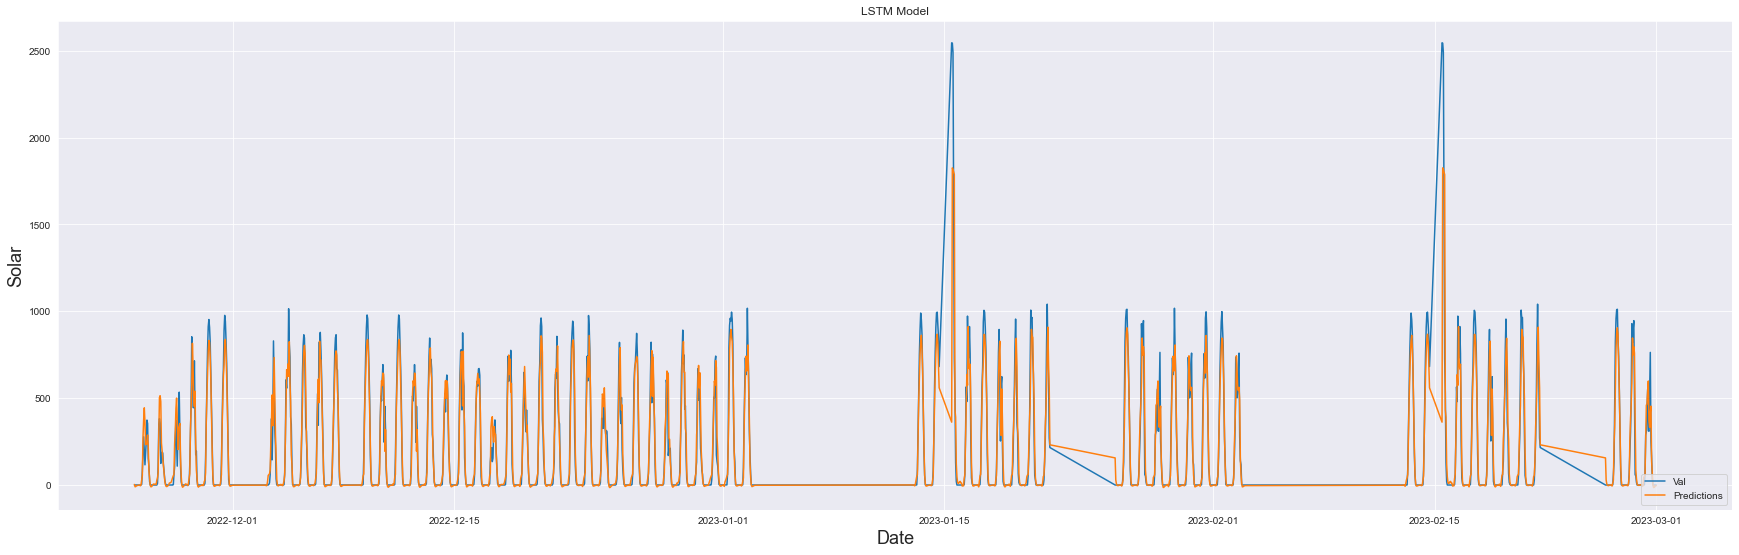

In [ ]:
plt.figure(figsize=(30,9))
plt.title('LSTM Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Solar', fontsize=18)
plt.plot(lstmvalid[['Solar Avg', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
lstmvalid.iloc[:,[0,-1]].to_csv('predictions/LSTM predictions.csv')

## ELM:

In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
import numpy as np

def create_elm_model(hidden_units, activation, learning_rate):
    elm_model = Sequential()
    elm_model.add(Dense(hidden_units, input_dim=x_train.shape[1], activation=activation, kernel_initializer='he_uniform'))
    elm_model.add(Dense(1))
    optimizer = optimizers.Adam(lr=learning_rate)
    elm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    print('#',end='')
    return elm_model

# Define the function to be optimized and the hyperparameter bounds
def hyp_opt(hidden_units, learning_rate):
    model = KerasRegressor(build_fn=create_elm_model, hidden_units=hidden_units, activation='relu', learning_rate=learning_rate, verbose=0)
    scores = -1 * cross_val_score(model, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
    return np.mean(scores)

pbounds = {'hidden_units': (32, 128),
           'learning_rate': (0.001, 0.1)}

# Perform Bayesian Optimization
optimizer = BayesianOptimization(f=hyp_opt, pbounds=pbounds, random_state=42)
optimizer.maximize(n_iter=10, init_points=5)

# Print the best hyperparameters
print(optimizer.max['params'])


|   iter    |  target   | hidden... | learni... |
-------------------------------------------------
#####| 1         | 0.1303    | 67.96     | 0.09512   |
#####| 2         | 0.1151    | 102.3     | 0.06027   |
#####| 3         | 0.1161    | 46.98     | 0.01644   |
#####| 4         | 0.114     | 37.58     | 0.08675   |
#####| 5         | 0.1325    | 89.71     | 0.0711    |
#####| 6         | 0.1084    | 84.07     | 0.09592   |
#####| 7         | 0.1339    | 89.63     | 0.0526    |
#####| 8         | 0.1322    | 88.81     | 0.1       |
#####| 9         | 0.1054    | 69.2      | 0.09799   |
#####| 10        | 0.1214    | 67.02     | 0.05398   |
#####| 11        | 0.1172    | 87.74     | 0.01842   |
#####| 12        | 0.1162    | 91.56     | 0.002105  |
#####| 13        | 0.1141    | 125.7     | 0.04184   |
#####| 14        | 0.1283    | 89.22     | 0.0943    |
#####| 15        | 0.1146    | 88.42     | 0.02169   |
{'hidden_units': 89.63441410309174, 'learning_rate': 0.05259792160639668}


This code performs hyperparameter tuning using GridSearchCV for an ELM model with a single hidden layer, by testing different combinations of the number of hidden units, activation function, and learning rate, and finds the best hyperparameters that give the highest score.

In [ ]:
elm_model = create_elm_model(activation='relu',
                          hidden_units=round(optimizer.max['params']['hidden_units']),
                          learning_rate=optimizer.max['params']['learning_rate'])

elm_model.fit(x_train, y_train, epochs=50, callbacks=[early_stopping])

#Epoch 1/50
191/191 [==============================] - 0s 678us/step - loss: 0.3101
Epoch 2/50
191/191 [==============================] - 0s 656us/step - loss: 0.1054
Epoch 3/50
191/191 [==============================] - 0s 654us/step - loss: 0.0968
Epoch 4/50
191/191 [==============================] - 0s 649us/step - loss: 0.0988
Epoch 5/50
191/191 [==============================] - 0s 650us/step - loss: 0.1095
Epoch 6/50
191/191 [==============================] - 0s 644us/step - loss: 0.1193
Epoch 7/50
191/191 [==============================] - 0s 655us/step - loss: 0.1003
Epoch 8/50
191/191 [==============================] - 0s 664us/step - loss: 0.0981


This code trains the ELM model with the best hyperparameters found using GridSearchCV in the previous code block.

In [ ]:
ELMpredictions = elm_model.predict(x_test)
ELMpredictions = target_scaler.inverse_transform(ELMpredictions)
y_test_descaled = target_scaler.inverse_transform(y_test)
ELMmae = mean_absolute_error(y_test_descaled, ELMpredictions)
ELMmse = mean_squared_error(y_test_descaled, ELMpredictions)
ELMrmse = np.sqrt(ELMmse)
ELMr2 = r2_score(y_test_descaled, ELMpredictions)
ELMaic = aic(y_test, ELMpredictions, x_test)
ELMmape = mean_absolute_percentage_error(y_test, ELMpredictions) * 100
print(f'''
(a) ELM Mean Absolute Error (ELMMAE): {ELMmae}
(b) ELM Mean Squared Error (MELMSE): {ELMmse}
(c) ELM Root Mean Squared ErrELMor (RMSE): {ELMrmse}
(d) ELM R² (R-Squared):{ELMr2}
(e) ELM AIC : {ELMaic.iloc[0]}
(f) ELM MAPE : {ELMmape}
''')

48/48 [==============================] - 0s 550us/step

(a) ELM Mean Absolute Error (ELMMAE): 61.08364787000486
(b) ELM Mean Squared Error (MELMSE): 17317.758985245302
(c) ELM Root Mean Squared ErrELMor (RMSE): 131.59695659568007
(d) ELM R² (R-Squared):0.849962919508821
(e) ELM AIC : -10.510342125485636
(f) ELM MAPE : 50469.18772821307



#### Plotting the ELM predictions:

In [ ]:
train = data[:len(x_train)]
elmvalid = data[len(x_train):]
elmvalid['Predictions'] = ELMpredictions

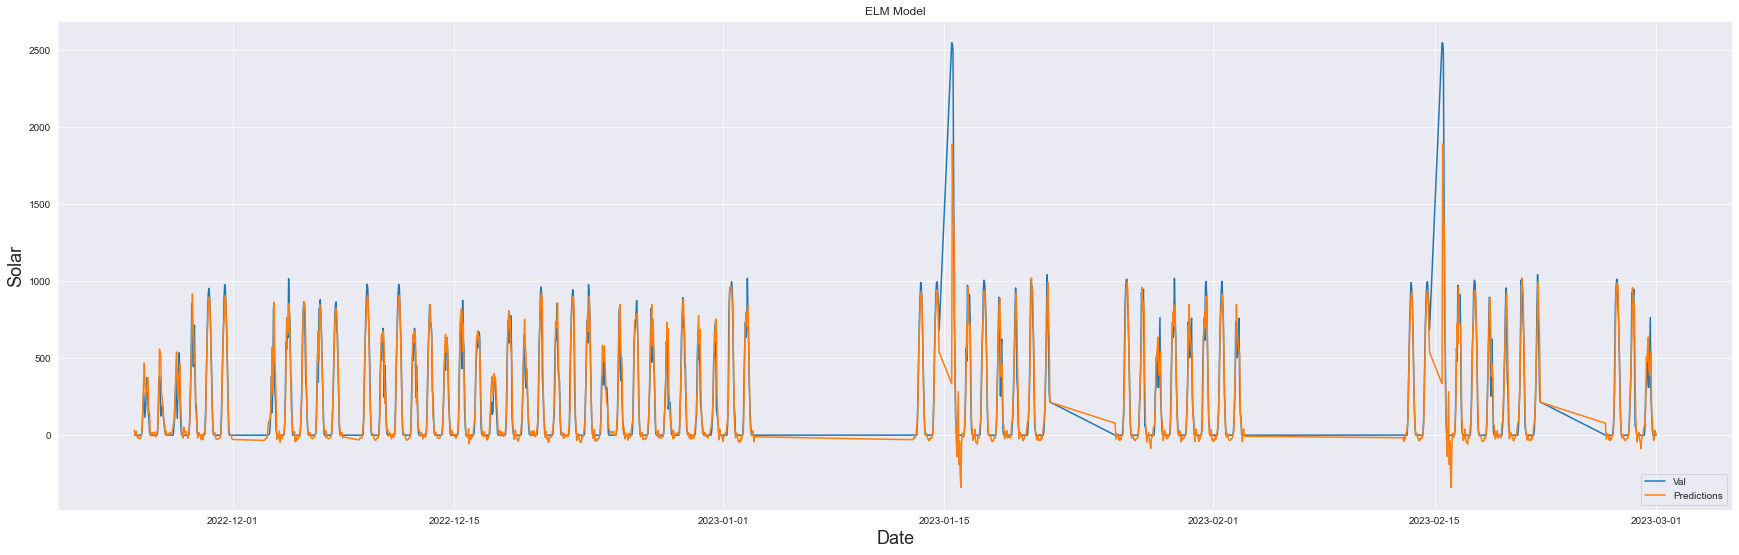

In [ ]:
plt.figure(figsize=(30,9))
plt.title('ELM Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Solar', fontsize=18)
# plt.plot(train['AllSky_Irr (Wh/m^2)'])
plt.plot(elmvalid[['Solar Avg', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
elmvalid.iloc[:,[0,-1]].to_csv('predictions/ELM predictions.csv')

## Hypered-Model:

In [ ]:
from keras.models import Model
from keras.layers import Input, Concatenate, Dense

# Create a new input layer for your ensemble model
input_layer = Input(shape=(X.shape[1],))

# Get the output from the LSTM model and ELM model
lstm_output = lstm_model(input_layer)
elm_output = elm_model(input_layer)

# Concatenate the outputs
concat_output = Concatenate()([lstm_output, elm_output])

# Add a dense layer to the concatenated output
dense_output = Dense(1)(concat_output)

# Create a new model that takes the input layer and produces the dense output
ensemble_model = Model(inputs=input_layer, outputs=dense_output)

# Compile the ensemble model
ensemble_model.compile(loss='mean_squared_error', optimizer='adam')

# Train the ensemble model
ensemble_model.fit(x_train, y_train, epochs=50, callbacks=[early_stopping])

Epoch 1/50
191/191 [==============================] - 8s 31ms/step - loss: 0.1878
Epoch 2/50
191/191 [==============================] - 6s 31ms/step - loss: 0.0957
Epoch 3/50
191/191 [==============================] - 6s 31ms/step - loss: 0.0892
Epoch 4/50
191/191 [==============================] - 6s 31ms/step - loss: 0.0855
Epoch 5/50
191/191 [==============================] - 6s 31ms/step - loss: 0.0896
Epoch 6/50
191/191 [==============================] - 6s 31ms/step - loss: 0.0837
Epoch 7/50
191/191 [==============================] - 6s 31ms/step - loss: 0.0827
Epoch 8/50
191/191 [==============================] - 6s 32ms/step - loss: 0.0805
Epoch 9/50
191/191 [==============================] - 6s 32ms/step - loss: 0.0799
Epoch 10/50
191/191 [==============================] - 6s 31ms/step - loss: 0.0788
Epoch 11/50
191/191 [==============================] - 6s 31ms/step - loss: 0.0792
Epoch 12/50
191/191 [==============================] - 6s 31ms/step - loss: 0.0784
Epoch 13/50
1

This code is creating an ensemble model that combines the output of two previously trained models, an LSTM model (lstm_model) and an ELM model (elm_model).

First, an input layer is created with the same shape as the input data used to train the two models. Then, the output from both models is obtained by passing the input layer as input to each model. The output of the two models is concatenated using the Concatenate() layer.

After the concatenation, a dense layer is added to the concatenated output. The output of this dense layer is then passed as output to a new model, called the ensemble_model, which takes the input layer and produces the dense output.

Finally, the ensemble_model is compiled with the mean squared error as loss function and the Adam optimizer. The model is then trained using the training data with 40 epochs.

In [ ]:
Hyperedpredictions = ensemble_model.predict(x_test)
Hyperedpredictions = target_scaler.inverse_transform(Hyperedpredictions)
y_test_descaled = target_scaler.inverse_transform(y_test)
Hyperedmae = mean_absolute_error(y_test_descaled, Hyperedpredictions)
Hyperedmse = mean_squared_error(y_test_descaled, Hyperedpredictions)
Hyperedrmse = np.sqrt(Hyperedmse)
Hyperedr2 = r2_score(y_test_descaled, Hyperedpredictions)
Hyperedaic = aic(y_test, Hyperedpredictions, x_test)
Hyperedmape = mean_absolute_percentage_error(y_test, Hyperedpredictions) * 100
print(f'''
(a) Hypered Mean Absolute Error (HyperedMAE): {Hyperedmae}
(b) Hypered Mean Squared Error (MHyperedSE): {Hyperedmse}
(c) Hypered Root Mean Squared ErrHyperedor (RMSE): {Hyperedrmse}
(d) Hypered R² (R-Squared):{Hyperedr2}
(e) Hypered AIC : {Hyperedaic}
(f) Hypered MAPE : {Hyperedmape}
''')

48/48 [==============================] - 1s 10ms/step

(a) Hypered Mean Absolute Error (HyperedMAE): 55.454417188959965
(b) Hypered Mean Squared Error (MHyperedSE): 13865.687483496857
(c) Hypered Root Mean Squared ErrHyperedor (RMSE): 117.75265382783039
(d) Hypered R² (R-Squared):0.8798708729692207
(e) Hypered AIC : Solar Avg   -10.48
dtype: float64
(f) Hypered MAPE : 51342.351783305



#### Plotting the gru-model predictions:

In [ ]:
train = data[:len(x_train)]
valid = data[len(x_train):]
valid['Predictions'] = Hyperedpredictions

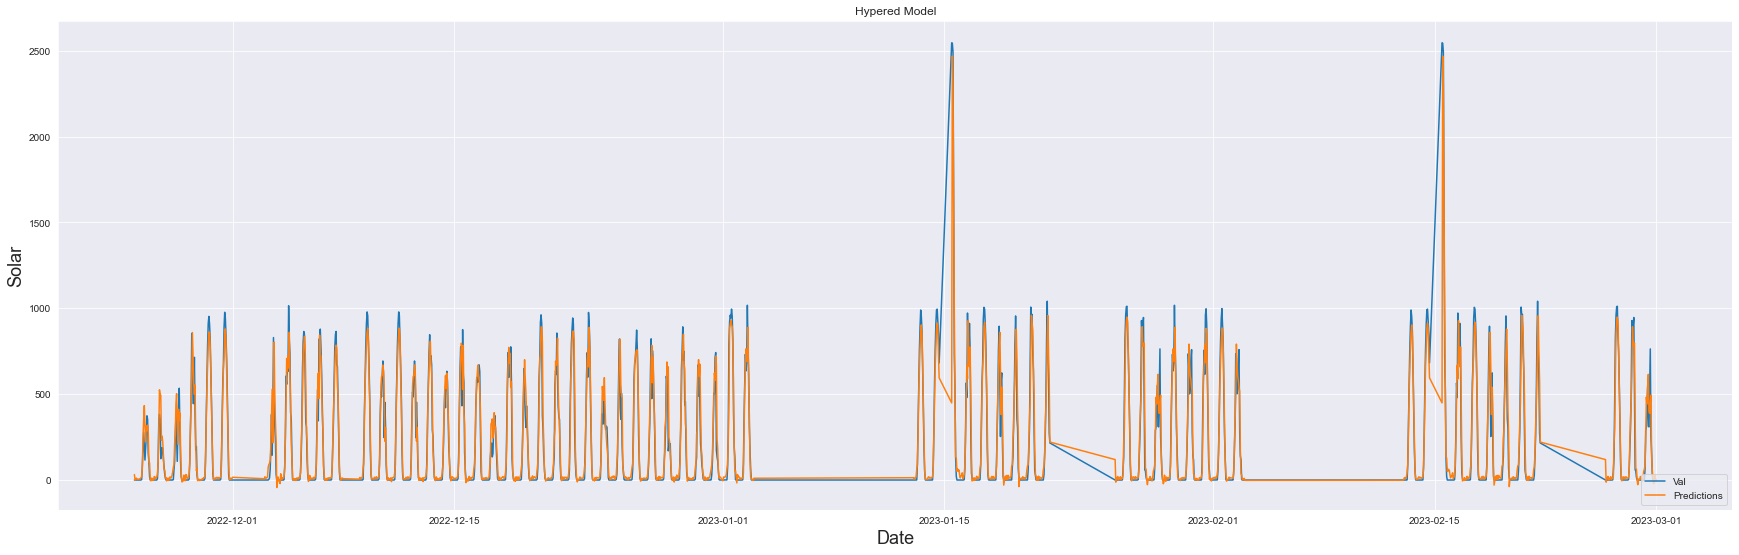

In [ ]:
plt.figure(figsize=(30,9))
plt.title('Hypered Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Solar', fontsize=18)
plt.plot(valid[['Solar Avg', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
valid.iloc[:,[0,-1]].to_csv('predictions/Hypered predictions.csv')

In [ ]:
from pickle import dump

with open('scalers/target_scaler.pkl', 'wb') as pickle_file:
    dump(target_scaler, pickle_file)
with open('scalers/data_scaler.pkl', 'wb') as pickle_file:
    dump(data_scaler, pickle_file)

In [ ]:
lstm_model.fit(scaled_data, scaled_target, epochs=50, callbacks=[early_stopping])
lstm_model.save('models/LSTM.h5')
elm_model.fit(scaled_data, scaled_target, epochs=50, callbacks=[early_stopping])
elm_model.save('models/ELM.h5')
ensemble_model.fit(scaled_data, scaled_target, epochs=50, callbacks=[early_stopping])
ensemble_model.save('models/Ens.h5')

Epoch 1/50
239/239 [==============================] - 7s 31ms/step - loss: 0.1830
Epoch 2/50
239/239 [==============================] - 7s 31ms/step - loss: 0.1130
Epoch 3/50
239/239 [==============================] - 8s 32ms/step - loss: 0.1099
Epoch 4/50
239/239 [==============================] - 8s 32ms/step - loss: 0.1073
Epoch 5/50
239/239 [==============================] - 8s 33ms/step - loss: 0.1093
Epoch 6/50
239/239 [==============================] - 8s 32ms/step - loss: 0.1076
Epoch 7/50
239/239 [==============================] - 7s 31ms/step - loss: 0.1091
Epoch 8/50
239/239 [==============================] - 8s 31ms/step - loss: 0.1036
Epoch 9/50
239/239 [==============================] - 7s 31ms/step - loss: 0.0965
Epoch 10/50
239/239 [==============================] - 7s 31ms/step - loss: 0.0948
Epoch 11/50
239/239 [==============================] - 7s 31ms/step - loss: 0.0947
Epoch 12/50
239/239 [==============================] - 7s 31ms/step - loss: 0.0942
Epoch 13/50
2

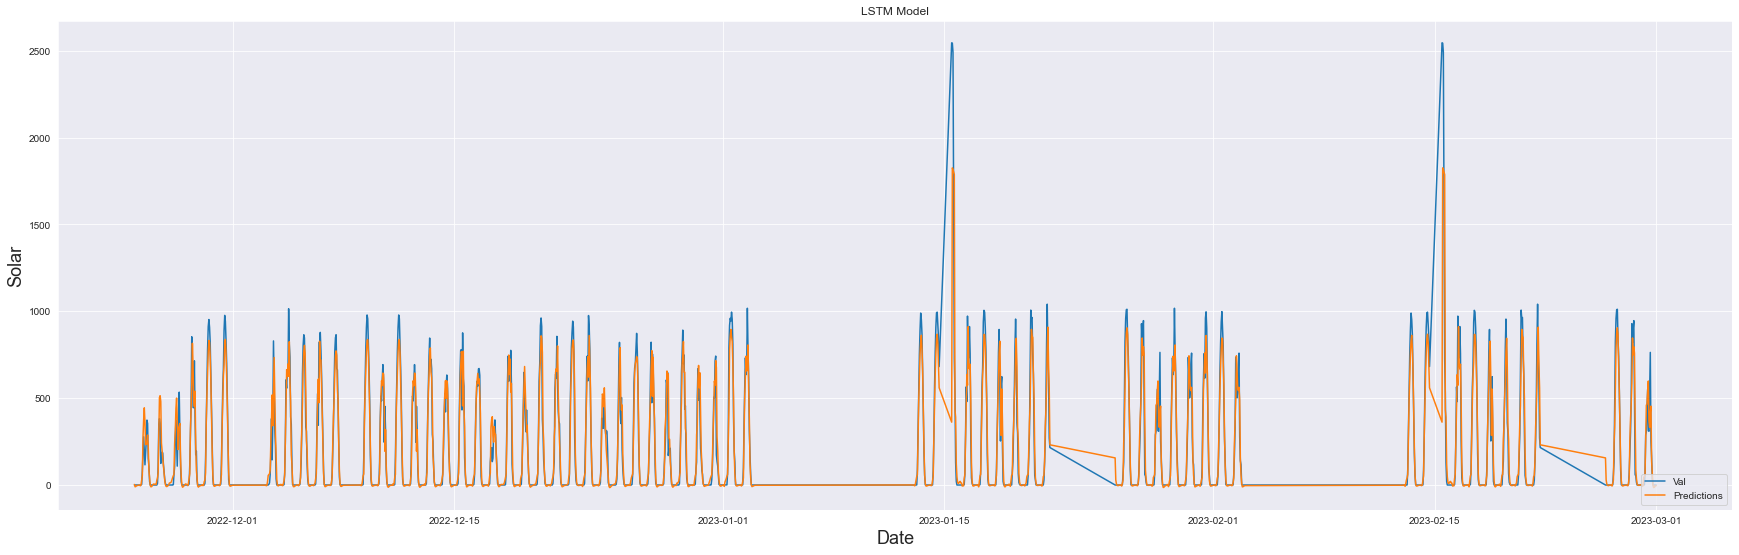

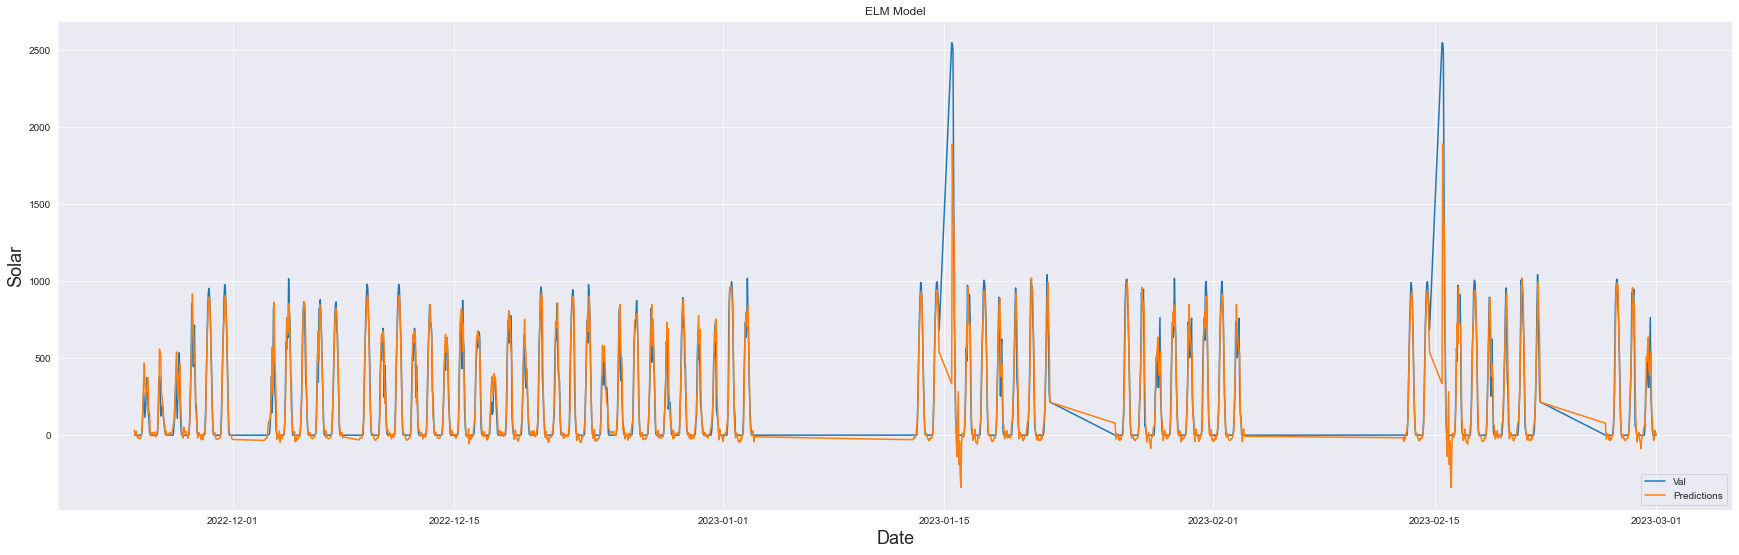

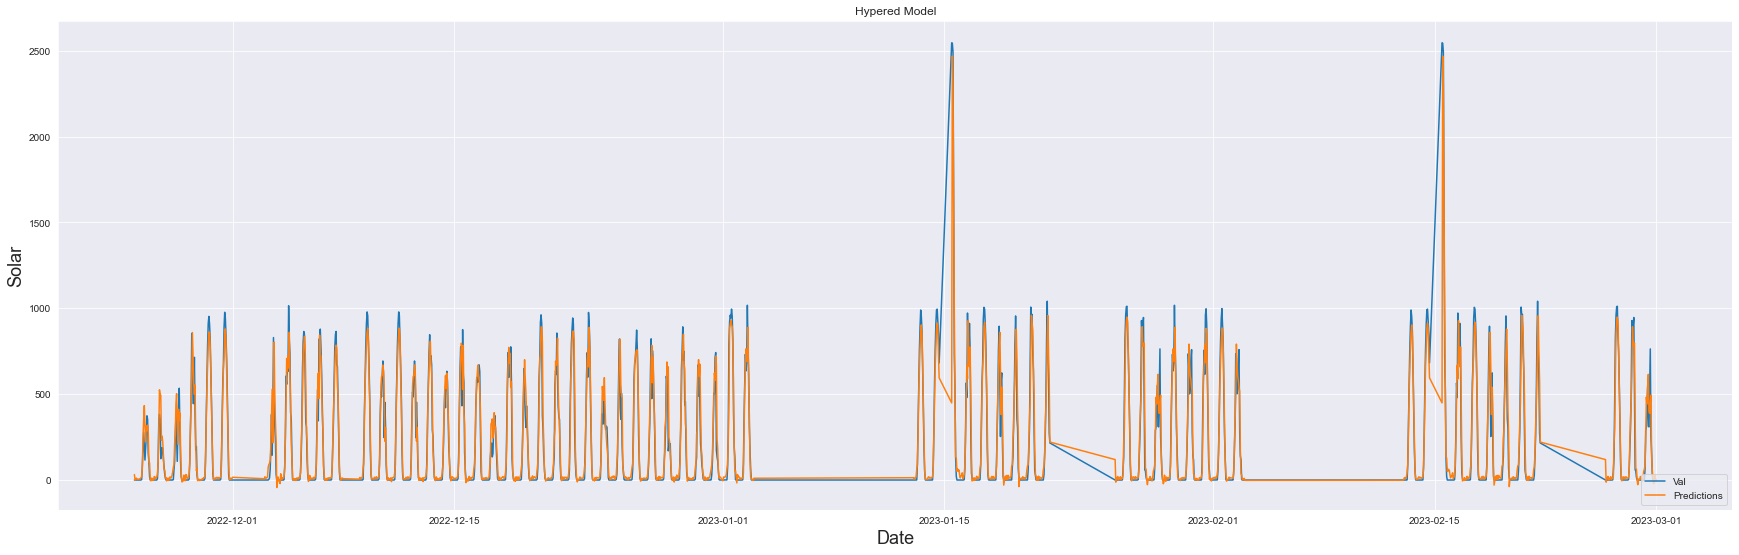

In [ ]:
plt.figure(figsize=(30,9))
plt.title('LSTM Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Solar', fontsize=18)
plt.plot(lstmvalid[['Solar Avg', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()
plt.figure(figsize=(30,9))
plt.title('ELM Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Solar', fontsize=18)
plt.plot(elmvalid[['Solar Avg', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()
plt.figure(figsize=(30,9))
plt.title('Hypered Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Solar', fontsize=18)
plt.plot(valid[['Solar Avg', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()